Tutorial 4: Integrating Multimodal Data with Ternary Plots
==========================================================

In Tutorial 2, we showed how to use the Laplacian score to determine whether a cell feature varies throughout the morphology space. Here, we discuss another technique to relate morphological distances to other cell features; in particular, we relate morphological distances to electrophysiological and molecular features of the cells. This technique allows us to identify variation in cells which is reflected _well_ through at least one of the indicators, but is reflected _poorly_ in the other indicators. It thus reveals "blind spots" in one of the measurement techniques, demonstrating the failure of one of the modes to capture distinctions which are well-reflected in the other modes.

Suppose that we have a set of cells $c_1,\dots, c_n$, and we associate to each cell an electrophysiological feature vector $e_1,\dots, e_n\in\mathbb{R}^k$, and a molecular feature vector $m_1,\dots, m_n\in \mathbb{R}^s$. Both the sets $\{e_1,\dots, e_n\}$ and $\{m_1,\dots, m_n\}$ can be regarded as spaces, and we can interpret the distance $\lVert e_i - e_j\rVert$ as the difference between cells $c_i,c_j$ which is visible from the point of view of electrophysiology; likewise for the molecular feature vectors. Together with the Gromov-Wasserstein space of morphological distances, this gives three different manifestations of the cell space, where the notion of distance of each space reflects one aspect of the cell.

Speaking broadly, we expect cells that are very different morphologically and very different electrophysiologically to be very different in their gene expression, as well. If there are many cell pairs in the data where large morphological and large electrophysiological distances aren't accompanied by large transcriptomic differences, it raises the question of why there is substantial variation in one variable not reflected in the others. For example, we might ask whether the transcriptomic methods are sufficiently comprehensive. This leads us to plot morphological, electrophysiological, and transcriptomic distances together.

This tutorial follows the dataset from the paper [Phenotypic variation of transcriptomic cell types in mouse motor cortexl](https://www.nature.com/articles/s41586-020-2907-3) by Scala et. al.
This [folder](https://www.dropbox.com/scl/fo/qqvbjfhitcaetxf4u6i87/h?rlkey=rn5xpegeden8sdmirjl1fav2j&dl=0) contains the SWC files and metadata we will use for the analysis; we refer to it below as `bd` for "base directory".

In [10]:
import os
import scipy
from scipy.spatial.distance import squareform, pdist
from os.path import join
import pandas as pd
import cajal, cajal.wnn
from cajal.utilities import dist_mat_of_dict, read_gw_dists, louvain_clustering
from cajal.ternary import ternary_distance
import anndata as ad
import scanpy as sc
import umap
import matplotlib.pyplot as plt
import sklearn.manifold

import numpy as np
from cajal import run_gw, sample_swc, swc

bd = '/home/jovyan/ternary_example'

As in the other tutorials, we compute the intracell distance matrices and then the Gromov-Wasserstein distance matrix.

In [7]:
sample_swc.compute_icdm_all_euclidean(
    infolder=join(bd,'ternary_swcs'),
    out_csv=join(bd,'euclidean_100_icdm.csv'),
    n_sample=100,
    num_processes=20,
    preprocess=swc.preprocessor_eu([1,3,4],soma_component_only=False)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 644/645 [11:46<00:01,  1.10s/it]


[]

In [8]:
run_gw.compute_gw_distance_matrix(
    intracell_csv_loc=join(bd,'euclidean_100_icdm.csv'),
    gw_dist_csv_loc=join(bd,'euclidean_100_gw.csv'),
    num_processes=20,
    verbose=True
)

  0%|          | 0/207690 [00:00<?, ?it/s]

(array([[ 0.        , 21.32632927, 26.68169293, ..., 54.26964935,
         39.29128812, 15.63981484],
        [21.32632927,  0.        , 29.50356163, ..., 53.90231398,
         43.15216615, 23.81994127],
        [26.68169293, 29.50356163,  0.        , ..., 49.07262993,
         39.84249075, 20.86042869],
        ...,
        [54.26964935, 53.90231398, 49.07262993, ...,  0.        ,
         81.7100187 , 44.57177175],
        [39.29128812, 43.15216615, 39.84249075, ..., 81.7100187 ,
          0.        , 48.51148557],
        [15.63981484, 23.81994127, 20.86042869, ..., 44.57177175,
         48.51148557,  0.        ]]),
 None)

The file "m1_patchseq_meta_data.csv" contains the RNA families for the samples profiled in the study.

In [14]:
metadata = pd.read_csv(join(bd,"m1_patchseq_meta_data.csv"), delimiter="\t", index_col=1)
# Start with 1329 rows × 32 columns

cells, gw_dist_dict = read_gw_dists(join(bd,'euclidean_100_gw.csv'),header=True)

In [15]:
metadata = metadata.loc[cells]
metadata = metadata.loc[metadata['RNA family']!='low quality']
# We will filter out the RNA families with few elements.
metadata[(metadata['RNA family'].value_counts() > 30)[metadata['RNA family']].array]

# Labels for the classifier
print(metadata['RNA family'].unique())

['ET' 'IT' 'Pvalb' 'Vip' 'Sst' 'Lamp5' 'CT' 'Sncg' 'NP']


The files containing electrophysiological data and the exon counts have been cleaned to discard samples containing NaN values.

In [16]:
m1_patchseq_ephys_features=pd.read_csv(join(bd,'m1_patchseq_ephys_features.csv'),index_col='cell id')

In [19]:
ephys_data = pd.read_csv(join(bd,'ephys_data.csv'),index_col='cell id')
exon_data = pd.read_csv(join(bd,'exon_data.csv'), index_col='cell id')

We restrict to the samples for which we have all threee - morphological data, exon counts, and electrophysiology data.

In [20]:
common_cells = list(set(metadata.index).intersection(set(exon_data.index)).intersection(ephys_data.index))

In [21]:
# common_cells = list(set(metadata.index).intersection(set(exon_data.index)).intersection(ephys_data.index))
metadata = metadata.loc[common_cells]
exon_data = exon_data.loc[common_cells]
ephys_data = ephys_data.loc[common_cells]

We normalize the columns in the electrophysiology data so that they have mean 0 and standard deviation 1.
The "distance" in the electrophysiology space between two samples is defined to be 1 minus the Pearson correlation coefficient between the data for the samples. This is not a metric, but it is a common technique.

In [22]:
ephys_data = (ephys_data - ephys_data.mean())
ephys_data /= ephys_data.std()
ephys_dmat = (1-ephys_data.transpose().corr())
# ephys_dmat = pd.DataFrame(squareform(pdist(ephys_data)), columns = common_cells, index = common_cells)

The following heuristic transformation is meant to narrow the long tails at the end of the distribution of exon counts.
As with the electrophysiology data, we use "correlation distance" as our notion of dissimilarity between samples.

In [23]:
exon_data = np.log(5000 * exon_data + 1)
exon_dmat = 1-((exon_data.transpose()).corr(method='pearson'))
gw_dmat = dist_mat_of_dict(gw_dist_dict,common_cells)

!
-3.1779289293017308
6.392055630800374


(<Figure size 400x2800 with 7 Axes>,
  <matplotlib.tri._tricontour.TriContourSet at 0x7faa66660b20>])

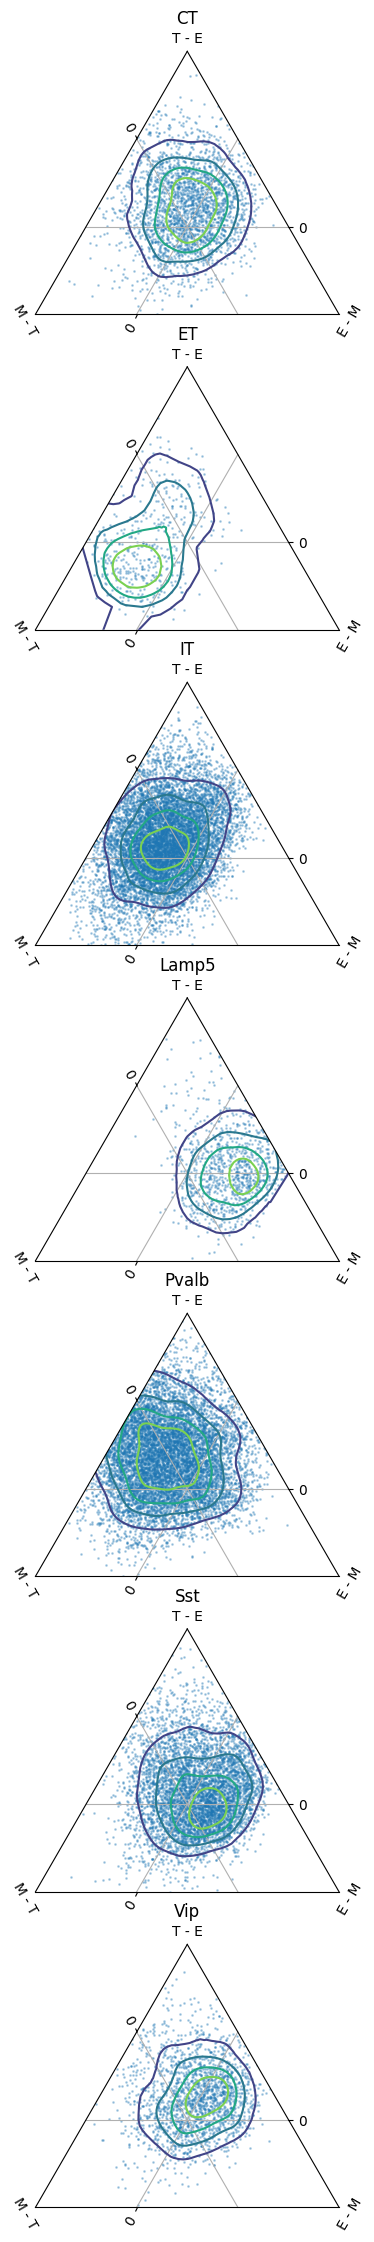

In [24]:
from cajal.ternary import ternary_distance_clusters
ternary_distance_clusters(
    exon_dmat.to_numpy(),
    'T', # Transcriptomic
    ephys_dmat.to_numpy(),
    'E', # Electrophysiological
    gw_dmat,
    'M', # Morphological
    density_estimation = 'gaussian_kde',
    bins = None,
    figsize = 4,
    clusters = metadata['RNA family'].to_numpy(),
    min_cluster_size = 30,
    mpl_params= { 's':1, 'alpha':.3 }
)

# Weighted Nearest Neighbors Analysis

In addition to investigating disparities in information between data sets, it is also important to integrate information from multiple data sets into a single coherent whole. For example, in the paper cited above, the authors integrate the transcriptomic space with the electrophysiological feature space via their technique of sparse reduced-rank regression. For this purpose, CAJAL provides the Weighted Nearest Neighbors algorithm developed in [Integrated analysis of multimodal single-cell data](https://www.nature.com/articles/s41587-023-01826-4) by Hao, Hao, Andersen-Nissen et. al. and [ported to Python by Dylan Kotliar](https://github.com/dylkot/pyWNN). Because the WNN algorithm was designed for datasets in Euclidean space, CAJAL represents the Gromov-Wasserstein space as a metric subspace of a Euclidean subspace of the same intrinsic dimension of the data using the Isomap embedding.

The Weighted Nearest Neighbors algorithm accepts two spaces (in our example, we consider the morphology space and electrophysiology space) and returns a similarity function which integrates the two data spaces. The relative influence of the two spaces varies throughout the space, and is locally biased at any point toward the space which is contributing more information in a neighborhood of that point.



In this example we show how to integrate an RNA-seq dataset with the Gromov-Wasserstein distance matrix.
First, we process the transcriptomic data via a standard pipeline from Scanpy, and we take the first principal components as the definition of our transcriptomic space.

In [25]:
def scanpy_load_clean(cell_names):
    # This closely follows the scanpy tutorial

    adata = ad.read_csv(join(bd,'exon_data.csv'))
    adata.var["gm"] = adata.var_names.str.startswith("Gm")
    adata.var["Rik"] = adata.var_names.str.endswith("Rik")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["gm", "Rik"], inplace=True, log1p=True
    )
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.scrublet(adata)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata)
    indices = [ adata.obs.index.get_loc(index) for index in cell_names]
    indices =np.array(indices)
    X_pca = adata.obsm['X_pca'][indices]
    return X_pca

In [26]:
transcriptome_pca=scanpy_load_clean(common_cells)
transcriptome_dmat = squareform(pdist(transcriptome_pca))

Before introducing WNN, let us look at the morphology space and the transcriptomic space separately.

In the first row, we plot a UMAP of the Gromov-Wasserstein morphology space; in the second row we plot the transcriptomic space.

The first column is colored by applying the Louvain clustering algorithm to the Gromov-Wasserstein space; the second column is colored by inferred transcriptomic type. (The authors of the paper "assign cell types \[using\] a nearest centroid classifier with Pearson correlation of log-expression across the most variable genes as a distance metric".)

In the first and fourth plots, the excellent clustering is somewhat tautological, as both the UMAP and the labels are both constructed from the same high-dimensional data; these are our ideal baseline. 
The second and fourth plots show that the inferred clusters from Gromov-Wasserstein are poorly localized in the transcriptomic space, and conversely.

In [27]:
morphology_labels = louvain_clustering(gw_dmat, 10)
RNA_family = metadata['RNA family'].values

In [28]:
reducer_precomputed = umap.umap_.UMAP(metric='precomputed',random_state=4)

In [29]:
def plot(ax, coords, labels, legend=True):
    # fig, ax = plt.subplots(figsize=(12,12))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    # a=reducer_precomputed.fit_transform(dmat)
    for label in np.unique(labels):
        xy = coords[np.nonzero([labels == label])[1]]
        ax.plot(xy[:,0], xy[:,1], marker = 'o', linestyle='', ms=3, label=label)
    if legend:
        ax.legend()

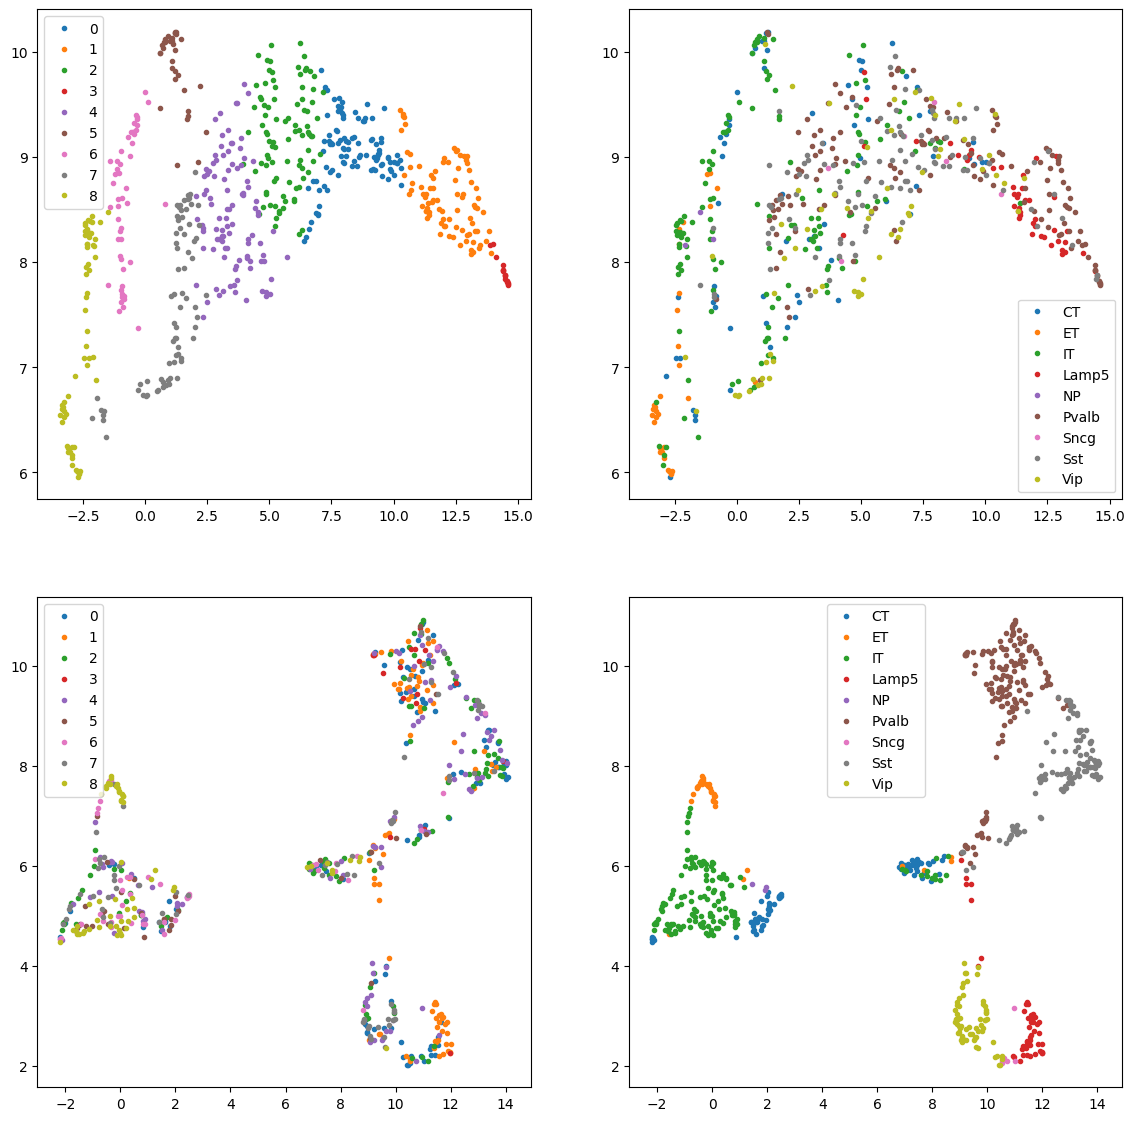

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
for i in range(2):
    dmat = [gw_dmat,transcriptome_dmat][i]
    v = reducer_precomputed.fit_transform(dmat)
    for j in range(2):
        labels = [morphology_labels,RNA_family][j]
        plot(ax[i,j],v,labels)

Beyond quantification, to quantify the degree to which the Gromov-Wasserstein morphology space preserves information about the transcriptomic space and conversely, we train a nearest-neighbors based classifier on one space to predict classes in the other space, and assess the accuracy and Matthews correlation coefficient of this regression.

In [31]:
def predict_classes_st_kfold_knn(X, clusters, dist_metric, nn, k, seed):
    # KNN version of https://github.com/applied-systems-biology/Dynamic_SPHARM
    # /blob/2588d3632e9b3d99486a75bfb50d21fc7a7c8070/SPHARM/lib/classification.py#L155
    import random
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
    
    clf = KNeighborsClassifier(metric=dist_metric, n_neighbors=nn, weights="distance")
    cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
    accuracy = pd.DataFrame({'Accuracy': cross_val_score(clf, X=X, y=clusters,cv=cv)})
    predicted = pd.DataFrame({'Actual class': clusters,
                              'Predicted class': cross_val_predict(clf, X=X, y=clusters, cv=cv)})
    return accuracy, predicted

def test_dmat(dmat, labels):
    from sklearn.metrics import matthews_corrcoef
    acc, pred = predict_classes_st_kfold_knn(dmat, labels, 'precomputed', 20, 7, 1)
    mcc = matthews_corrcoef(pred.iloc[:,0], pred.iloc[:,1])
    return(acc,mcc)

In [32]:
print(test_dmat(gw_dmat, morphology_labels))
print(test_dmat(gw_dmat, RNA_family))
print(test_dmat(transcriptome_dmat, morphology_labels))
print(test_dmat(transcriptome_dmat, RNA_family))

(   Accuracy
0  0.932584
1  0.977528
2  0.921348
3  0.853933
4  0.943182
5  0.931818
6  0.943182, 0.9184282194112591)
(   Accuracy
0  0.483146
1  0.471910
2  0.561798
3  0.449438
4  0.579545
5  0.386364
6  0.431818, 0.36514270173820573)
(   Accuracy
0  0.303371
1  0.269663
2  0.337079
3  0.337079
4  0.318182
5  0.329545
6  0.329545, 0.21315375914892834)
(   Accuracy
0  0.898876
1  0.921348
2  0.887640
3  0.932584
4  0.954545
5  0.875000
6  0.897727, 0.8909472227795456)


On 7-fold cross-validation, the accuracy of a k-nearest neighbors classifier(k=20) trained to predict transcriptomic types from the morphology space ranges from 0.38 to 0.54; the Matthews correlation coefficient (a form of accuracy controlled for class size) is .35. The first and fourth tables are references that indicate what an ideal indicator would look like; the results are of course near perfect as the classifier is simply trained using the same information used to construct the clusters.

Once we have defined these spaces, we can apply the weighted nearest neighbors algorithm to construct the similarity function.

In [33]:
from cajal.wnn import wnn
integrated_space = wnn(gw_dmat, transcriptome_pca, 240)

Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 620 0.00 seconds elapsed
Selecting top K neighbors


We visualize the integrated space using t-SNE. 
We color the points by their RNA family. It is visually clear that the WNN space strongly retains information about the transcriptomic type. The RNA families are well localized.

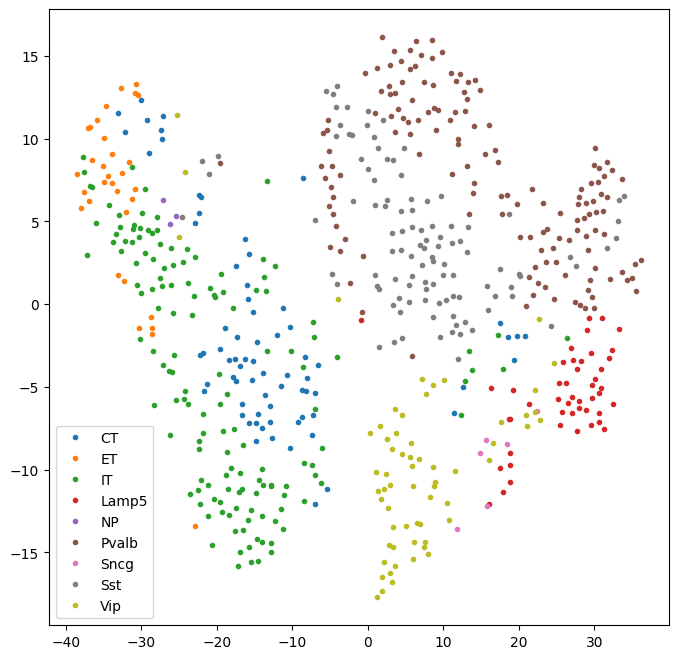

In [34]:
tsne = sklearn.manifold.TSNE(n_components=2, 
                             perplexity=30.0,
                             metric='precomputed',
                             init='random',
                             early_exaggeration=4.0,
                             random_state=4
                            )
wnn_embedding = tsne.fit_transform(integrated_space.obsp['WNN_distance'])

fig, ax = plt.subplots(figsize=(8,8))
plot(ax,wnn_embedding, RNA_family)
plt.show()

In previous examples we have used UMAP, but the similarity function returned by the weighted nearest neighbors algorithm is incompatible with UMAP; in particular, it is asymmetric. For this reason, the term "space" here is an abuse of language.
It is possible to use UMAP, however, by symmetrizing the matrix. We will take this approach for consistency with our previous analyses.

In [35]:
def symmetrize(a):
    a = a.todense()
    a[a == 0] = np.max(a)
    b = a + a.T
    b = np.minimum(a,b)
    b = np.minimum(b,a.T)
    d=np.zeros(a.shape[0],dtype=int)
    b[d,d]=0
    return np.array(b)

wnn_dmat = symmetrize(integrated_space.obsp['WNN_distance'])

The apparent clustering behavior is similar in the UMAP visualization.

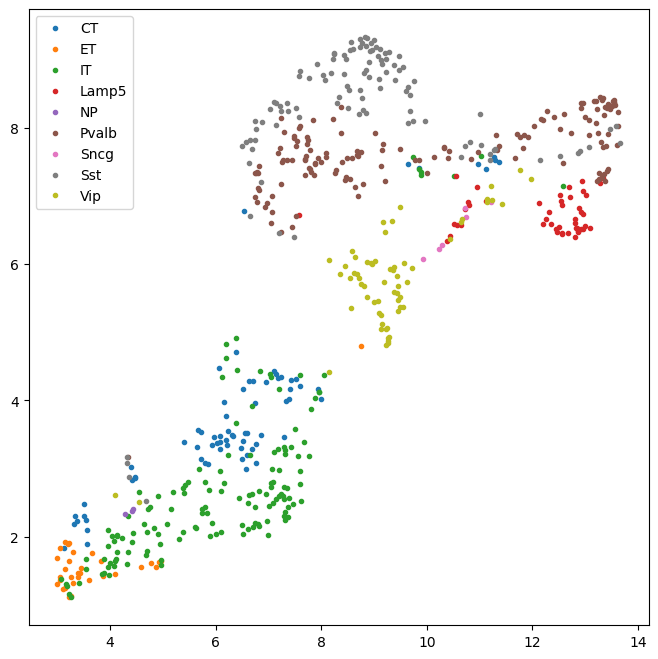

In [36]:
umap_coords = reducer_precomputed.fit_transform(wnn_dmat)
fig, ax = plt.subplots(figsize=(8,8))
plot(ax,umap_coords, RNA_family)
plt.show()

The k-nearest neighbors regression confirms the apparent clustering.

In [37]:
test_dmat(integrated_space.obsp['WNN_distance'], RNA_family)

(   Accuracy
 0  0.910112
 1  0.887640
 2  0.865169
 3  0.842697
 4  0.875000
 5  0.818182
 6  0.840909,
 0.8344851058074262)

The clusters defined using the Gromov-Wasserstein metric are still readily visible in the wnn space.

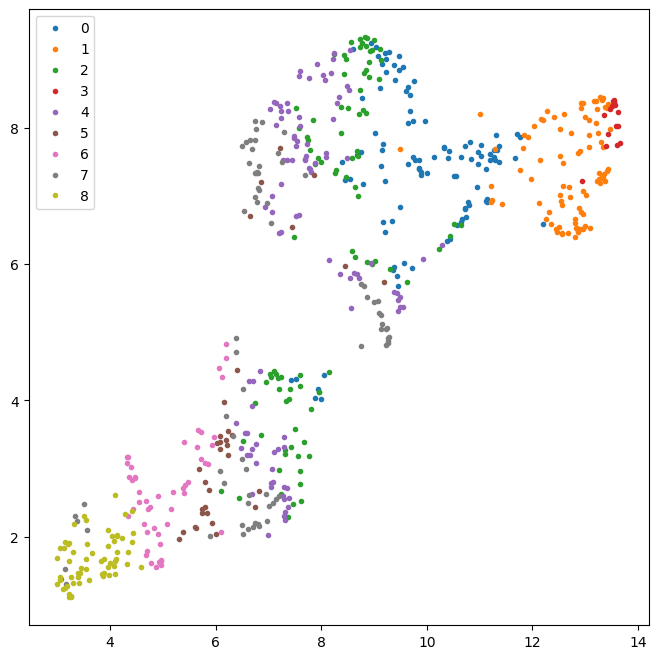

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
plot(ax,umap_coords, morphology_labels)
plt.show()

Again, using the k-nearest neighbors analysis, we can confirm that the Gromov-Wasserstein clusters are well-localized in the wnn space.

In [39]:
test_dmat(integrated_space.obsp['WNN_distance'], morphology_labels)

(   Accuracy
 0  0.842697
 1  0.887640
 2  0.797753
 3  0.853933
 4  0.875000
 5  0.840909
 6  0.784091,
 0.8163009734676837)

We carry out the same analysis to see how the weighted nearest neighbors space relates to the Gromov-Wasserstein space. We cluster the neurons in the GW morphology space, and then ask whether this clustering is well-preserved upon passing to the integrated space. Both by visual inspection of the t-SNE, and by measuring the accuracy of a k-nearest neighbors based classifier, it is evident that the integrated space incorporates very well the information of the GW morphology space.

Integrating morphology data with electrophysiology data is substantially similar to integrating morphology data with transcriptomic data; the function `cajal.wnn.wnn` can be used to integrate a distance matrix with any dataset in R^n. We clean the electrophysiology data following the *Phenotypic Variation...* paper, deleting a few unused electrophysiology variables, and normalizing each column to have the same variance. 

In [46]:
def clean_electrophys(ephys_data):
    remove_columns = [ 'Afterdepolarization (mV)', 'Burstiness', 'Rebound number of APs', 'Sag area (mV*s)', 'Sag time (s)', 
                      'Wildness', 'AP Fano factor',  'Latency @ +20pA current (ms)', 'ISI Fano factor', 'AP amplitude average adaptation index', 'ISI average adaptation index', 'Spike frequency adaptation']
    ephys_data = ephys_data.drop(columns = remove_columns)
    for column in ['AP coefficient of variation', 'ISI coefficient of variation','ISI adaptation index', 'Latency (ms)']:
        assert np.all(ephys_data[column]>0)
        ephys_data[column] = ephys_data[column].apply(np.log)
    for col in ephys_data.columns:
        ephys_data[col] /= np.std(ephys_data[col])
    return ephys_data

In [51]:
ephys_data = pd.read_csv(join(bd,'ephys_data.csv'),index_col='cell id')
ephys_data= ephys_data.loc[common_cells]
ephys_eu_dmat = squareform(pdist(clean_electrophys(ephys_data)))
integrated_ephys_space = wnn(gw_dmat, ephys_eu_dmat , 240)

Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 620 0.00 seconds elapsed
Selecting top K neighbors


The Louvain clusters from the GW space are well-localized in the integrated morphology space.
The wnn space retains much of the information about the GW metric.

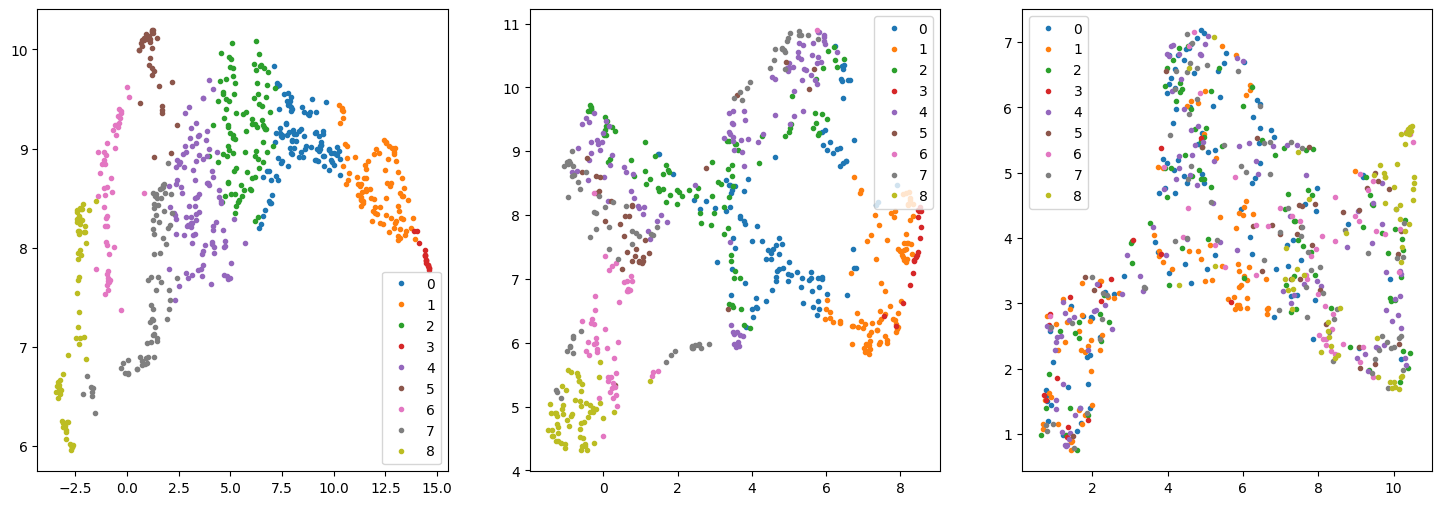

In [52]:
wnn_ephys = integrated_ephys_space.obsp['WNN_distance']
wnn_ephys_symmetric = symmetrize(wnn_ephys)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
for i in range(3):
    dmat = [gw_dmat, wnn_ephys_symmetric, ephys_eu_dmat][i]
    coords = reducer_precomputed.fit_transform(dmat)
    plot(ax[i],coords,morphology_labels)
plt.show()

In [55]:
for i in range(3):
    x,y = (test_dmat([gw_dmat, wnn_ephys, ephys_eu_dmat][i], morphology_labels))
    print(x)
    print("MCC",y)
del(x)
del(y)

   Accuracy
0  0.932584
1  0.977528
2  0.921348
3  0.853933
4  0.943182
5  0.931818
6  0.943182
MCC 0.9184282194112591
   Accuracy
0  0.820225
1  0.853933
2  0.808989
3  0.808989
4  0.863636
5  0.818182
6  0.818182
MCC 0.801580101318349
   Accuracy
0  0.280899
1  0.359551
2  0.314607
3  0.303371
4  0.363636
5  0.284091
6  0.261364
MCC 0.19966092001995403


# Integrating Electrophysiology data with Morphology Data

In this example, we draw on data from the paper ["Classification of electrophysiological and morphological neuron types in the mouse visual cortex"](https://www.nature.com/articles/s41593-019-0417-0) by Gouwens, Sorensen, Berg et. al.
The authors collect patch-clamp data and define three clusterings of the neurons based on morphology, electrophysiology, and a combination of morphological and electrophysiological data.

We load the electrophysiology data.

In [56]:
def get_ephys_data(bd):    
    df = pd.read_csv(join(bd,"cell_types_specimen_details.csv"))
    # Columns 18 through 28 are electrophysiological feature vectors.
    # Column 1 is the specimen id.
    ephys = df[df.columns[18:29].union(pd.Index(df.columns[1:2]))]
    ephys.index = ephys['specimen__id']
    # Drop the specimen id.
    ephys = ephys[ephys.columns[:-1]]
    return ephys

The authors have labeled many of the cells in the dataset by morphology type, electrophysiology type, and combined morphology-electrophysiology type. We load the labels and restrict to the set of cells which are annotated with each of the three types.

In [57]:
def read_cell_types(bd):
    type_labels = pd.read_csv(join(bd,'41593_2019_417_MOESM5_ESM.csv'))
    type_labels.index = type_labels['specimen_id']
    type_labels=type_labels.drop('specimen_id',axis=1)
    type_labels=type_labels[~(pd.isna(type_labels['e-type']) | pd.isna(type_labels['m-type']) | pd.isna(type_labels['me-type']))]
    return type_labels

In [59]:
cell_type_labels = read_cell_types(bd)

We normalize the electrophysiology data, clean it to remove NaN values, and take the logarithm of any nonnegative feature vector with a long tail.
We restrict to only those cells for which we have e-type labels.

In [60]:
def transform_ephys_data(ephys,cell_type_labels):
    ephys_transform =ephys.copy()
    # These columns were selected by heuristic/visual inspection of a histogram of the data.
    # This does not reflect the methodology of Gouwens, Sorensen, Berg et. al.
    for s in ['ef__avg_firing_rate','ef__avg_isi','ef__peak_t_ramp','ef__ri','ef__tau','ef__threshold_i_long_square']:
        ephys_transform[s]=np.log(ephys[s])
    # Restrict to only those cells
    df_cl_etypes = cell_type_labels[~(pd.isna(cell_type_labels['e-type']))]
    for col in ephys_transform.columns:
            ephys_transform[col] /= np.std(ephys_transform[col])
    ephys_transform=ephys_transform[ephys_transform.index.isin(df_cl_etypes.index)]
    ephys_transform=ephys_transform[~(ephys_transform.isna().transpose().any())]
    # ephys_labels =df_cl_etypes['e-type'].loc[ephys_transform.index]
    return ephys_transform

In [62]:
ephys_data = transform_ephys_data(get_ephys_data(bd), cell_type_labels)

In [63]:
cell_type_labels

,e-type,m-type,me-type,upright_angle,soma_distance_from_pia,estimated_shrinkage_factor,estimated_slice_angle
specimen_id,,,,,,,
313862022,Exc_3,Spiny_8,ME_Exc_6,150.319955,492.100275,2.977636,-25.453107
313862167,Inh_13,Aspiny_1,ME_Inh_15,119.629705,408.467273,2.030599,-21.213269
313862373,Inh_2,Aspiny_4,ME_Inh_7,249.183146,926.652428,1.614714,-29.985693
314642645,Exc_3,Spiny_3,ME_Exc_17,233.914695,372.685943,2.251238,24.773125
314804042,Exc_3,Spiny_4,ME_Exc_16,238.336909,492.354331,2.874654,-12.595367
...,...,...,...,...,...,...,...
698217104,Exc_3,Spiny_10,ME_Exc_8,132.192872,528.334779,2.022481,14.721539
698226504,Exc_3,Spiny_18,ME_Exc_2,141.786099,621.429913,2.515973,14.296986
698230720,Exc_3,Spiny_10,ME_Exc_8,140.199770,577.460428,3.777499,12.829926


In [64]:
ephys_data

,ef__adaptation,ef__avg_firing_rate,ef__avg_isi,ef__f_i_curve_slope,ef__fast_trough_v_long_square,ef__peak_t_ramp,ef__ri,ef__tau,ef__threshold_i_long_square,ef__upstroke_downstroke_ratio_long_square,ef__vrest
specimen__id,,,,,,,,,,,
485909730,0.259686,3.249984,4.533619,0.731650,-7.663822,1.730059,10.684161,5.406549,5.553525,2.870385,-14.094319
323865917,0.214655,2.661460,5.122144,0.480799,-7.468316,2.031086,10.189223,5.620548,5.553525,2.805544,-12.715539
476135066,0.792276,2.453961,5.329643,0.407783,-6.955114,2.903415,9.077866,5.770881,6.362717,3.194297,-13.753128
502614426,0.199358,2.872983,4.910621,0.454995,-8.035282,2.235112,10.692908,5.969551,5.882037,3.716793,-12.853864
480087928,0.147687,3.207325,4.576278,0.583020,-7.585619,1.906282,10.836386,6.399584,5.113697,3.322562,-13.412753
...,...,...,...,...,...,...,...,...,...,...,...
485835055,0.135440,3.147159,4.636445,0.452926,-7.404777,3.089337,9.047731,4.981259,6.713385,3.062437,-13.924463
474626527,0.286463,3.784035,3.999568,1.684352,-7.947305,1.674985,11.642129,5.371963,4.445959,2.197728,-11.471226
480353286,0.289393,2.484211,5.299392,0.354739,-6.832923,2.792334,9.468316,5.360538,6.362717,3.023148,-13.773041


Finally we restrict to the cells which have labels for each of the types, and we have a morphological reconstruction that is in our GW distance table.

In [66]:
gw_names, gw_dist_dict = read_gw_dists(join(bd,"gouwens_gw.csv"),header=True)
gw_dist_dict = cajal.utilities.update_names(int,gw_dist_dict)
gw_names = [int(name) for name in gw_names]
common_names = list(set(ephys_data.index).intersection(set(gw_names)).intersection(set(cell_type_labels.index)))
ephys_data = ephys_data.loc[common_names]
cell_type_labels = cell_type_labels.loc[common_names]
gw_dmat = dist_mat_of_dict(gw_dist_dict, common_names)

After loading, cleaning and formatting the data we can compute the weighted nearest neighbors similarity table.

In [74]:
wnn_data = cajal.wnn.wnn(gw_dmat, np.array(ephys_data.loc[common_names]), 250)

Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 377 0.00 seconds elapsed
Selecting top K neighbors


In [75]:
def plot_ephys(common_names, gw_dmat, wnn_data, ephys_data, type_labels):
    fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
    dmats =  [ gw_dmat, symmetrize(wnn_data.obsp['WNN_distance']), squareform(pdist(ephys_data))]
    labels = [ 'm-type', 'me-type', 'e-type' ]
    ylabels = ["GW space", "WNN space", "Ephys space"]
    # Each row corresponds to one of the morphology spaces
    for i in range(3):
        dmat = dmats[i]
        ax[i,0].set_ylabel(ylabels[i],rotation=0,size="large",labelpad=40)
        coords = reducer_precomputed.fit_transform(dmat)
        # Each column corresponds to one of the type labellings
        for j in range(3):
            ax[0,j].set_title(labels[j])
            plot(ax[i, j], coords, type_labels[labels[j]], legend=False)
    fig.tight_layout()

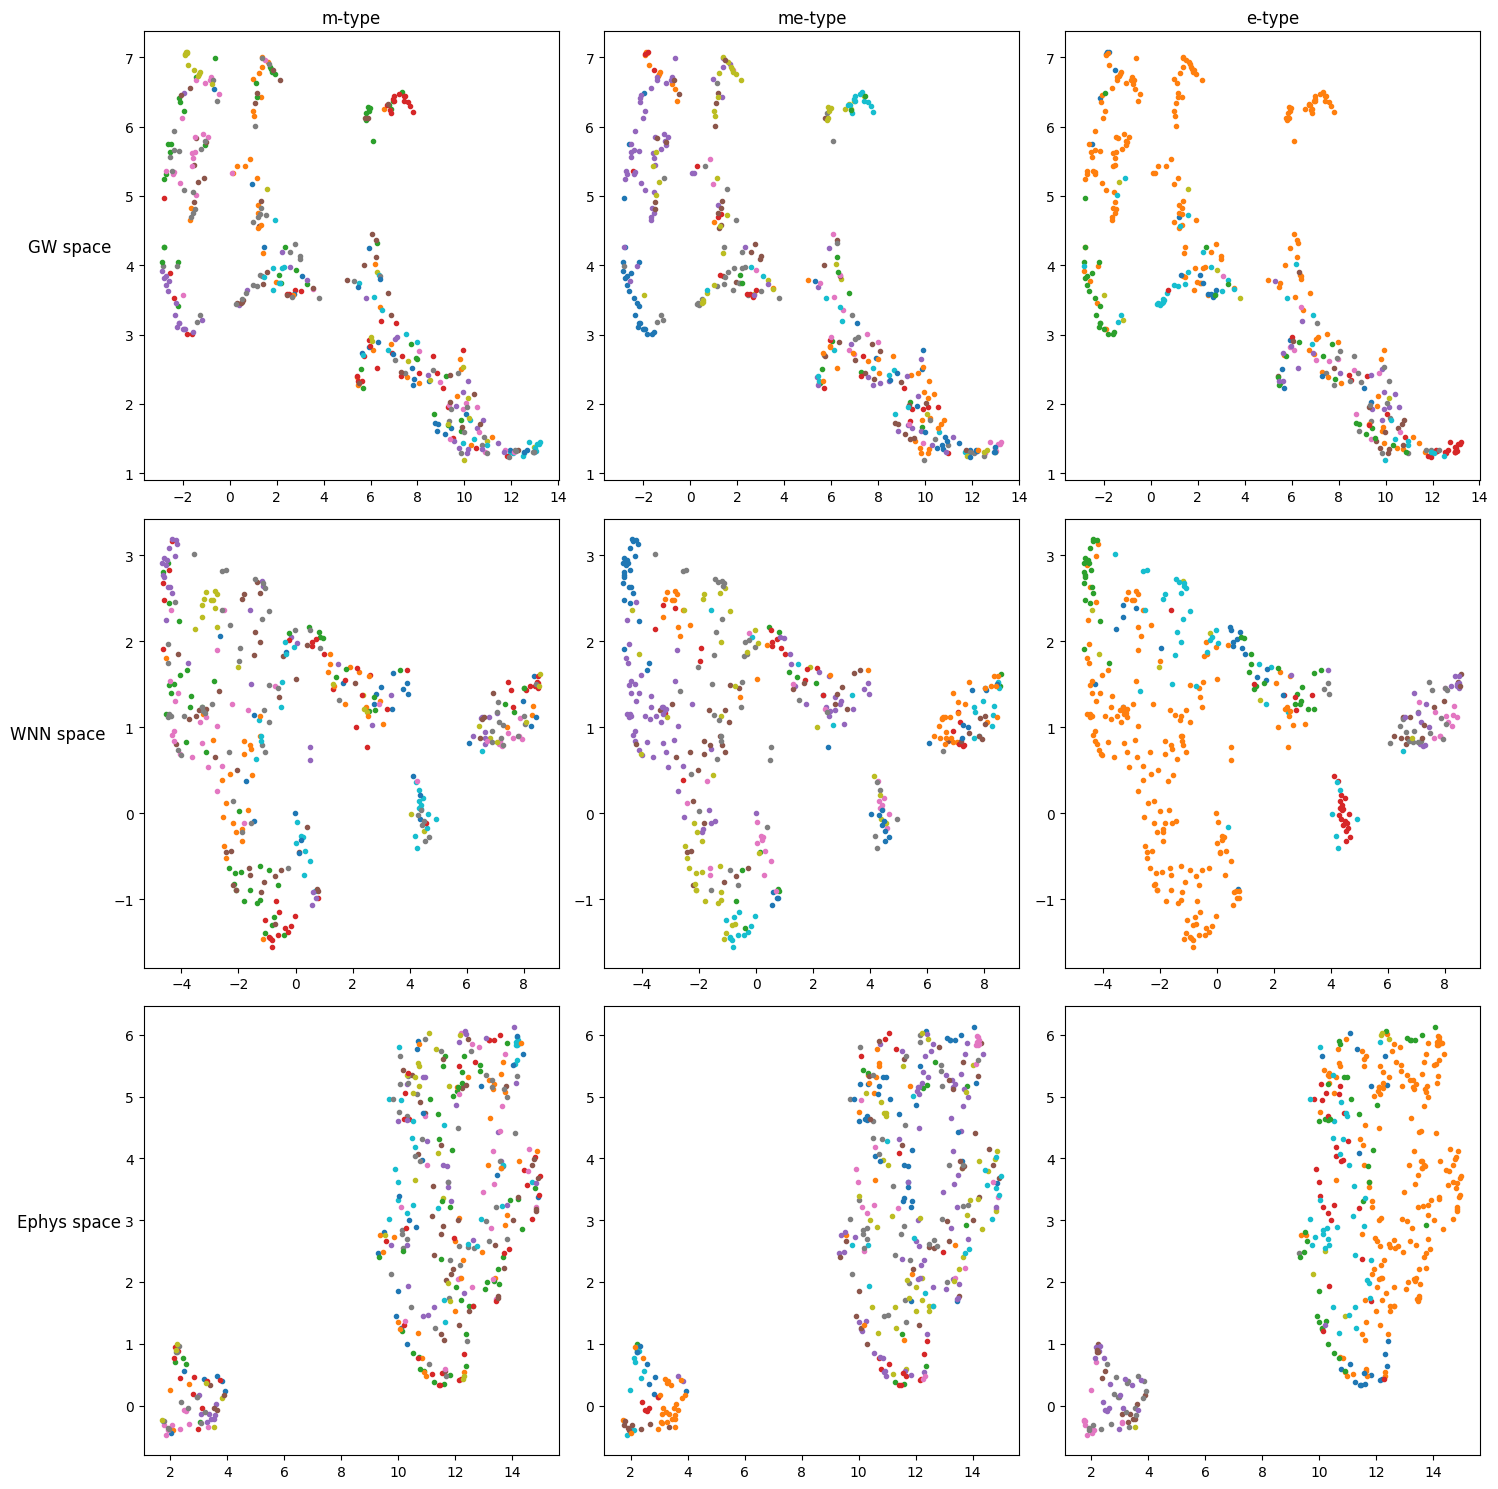

In [76]:
plot_ephys(common_names, gw_dmat, wnn_data, ephys_data,  cell_type_labels)

In [77]:
def test_clustering(common_names, gw_dmat, wnn_data, ephys_data, type_labels):
    dmats = [gw_dmat, wnn_data.obsp['WNN_distance'], squareform(pdist(ephys_data))]
    dmat_names = ['GW','WNN','Ephys' ]
    labels = [ 'm-type', 'me-type', 'e-type' ]
    ell = []
    for i in range(3):
        arr = np.zeros((3,))
        for j in range(3):
            _, mcc = test_dmat(dmats[i], type_labels[labels[j]])
            arr[j] = mcc
        ell.append(pd.Series(arr, index=labels,name=dmat_names[i]))
    return pd.DataFrame(ell)

In [78]:
test_clustering(common_names, gw_dmat, wnn_data, ephys_data, cell_type_labels)

,m-type,me-type,e-type
GW,0.305988,0.351362,0.408162
WNN,0.364146,0.475776,0.630810
Ephys,0.145729,0.350873,0.516452
